In [1]:
import torch
import numpy as np
from functools import partial
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ds_in = xr.open_dataset('/leap/NYC_data_128/generated_2012_2019/input_all.nc')
ds_tar = xr.open_dataset('/leap/NYC_data_128/generated_2012_2019/target_all.nc')
ds_out = xr.open_dataset('/leap/NYC_data_128/generated_2012_2019/output_all.nc')

In [3]:
ds_in

<xarray.Dataset> Size: 30GB
Dimensions:                    (time: 17544, y: 128, x: 128)
Coordinates:
  * time                       (time) datetime64[ns] 140kB 2012-01-01 ... 201...
    latitude                   (y, x) float64 131kB ...
    longitude                  (y, x) float64 131kB ...
    atmosphere                 float64 8B ...
    gribfile_projection        float64 8B ...
    step                       timedelta64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables: (12/13)
    2m_temperature             (time, y, x) float64 2GB ...
    temperature_500            (time, y, x) float64 2GB ...
    temperature_850            (time, y, x) float64 2GB ...
    total_column_water_vapour  (time, y, x) float64 2GB ...
    total_precipitation        (time, y, x) float64 2GB ...
    10m_u_component_of_wind    (time, y, x) float64 2GB ...
    ...                         ...
    u_component_of_wind_850    (time, y, x) float64 2GB ...
    10m_v_component_of_wind    (time, y, x) float64 2GB ...
    v_component_of_wind_500    (time, y, x) float64 2GB ...
    v_component_of_wind_850    (time, y, x) float64 2GB ...
    geopotential_500           (time, y, x) float64 2GB ...
    geopotential_850           (time, y, x) float64 2GB ...

In [4]:
def plot_comparison(ds_in, ds_tar, ds_out, common_channels, time_idx=0, ensembles=[0, 1, 2], 
                    vmin_dict=None, vmax_dict=None, cmap_dict=None, figsize=(20, 15)):
    """
    Plot comparison of input, target, and prediction datasets.
    
    Parameters:
    -----------
    ds_in : xr.Dataset
        Input dataset (ERA5)
    ds_tar : xr.Dataset
        Target dataset (HRRR)
    ds_out : xr.Dataset
        Output/prediction dataset
    common_channels : list
        List of variable names from ds_in that correspond to ds_tar/ds_out variables in order
    time_idx : int
        Time index to plot
    ensembles : list
        List of ensemble indices to plot
    vmin_dict : dict
        Dictionary mapping variable names to vmin values (using ds_tar variable names)
    vmax_dict : dict
        Dictionary mapping variable names to vmax values (using ds_tar variable names)
    cmap_dict : dict
        Dictionary mapping variable names to colormap names (using ds_tar variable names)
    figsize : tuple
        Figure size
    """
    if vmin_dict is None:
        vmin_dict = {}
    if vmax_dict is None:
        vmax_dict = {}
    if cmap_dict is None:
        cmap_dict = {}
    
    target_vars = list(ds_tar.data_vars)
    n_rows = 2 + len(ensembles)  # ERA5 + HRRR + ensemble rows
    n_cols = len(target_vars)
    
    plt.figure(figsize=figsize)
    
    # Plot ERA5 inputs (using common_channels mapping)
    for i, (in_var, tar_var) in enumerate(zip(common_channels, target_vars)):
        plt.subplot(n_rows, n_cols, 1 + i)
        vmin = vmin_dict.get(in_var, None)
        vmax = vmax_dict.get(in_var, None)
        cmap = cmap_dict.get(in_var, 'viridis')
        plt.pcolormesh(ds_in[in_var].isel(time=time_idx), vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar()
        plt.title(f'{in_var}\n(ERA5)')
    
    # Plot HRRR targets
    for i, var in enumerate(target_vars):
        plt.subplot(n_rows, n_cols, n_cols + 1 + i)
        vmin = vmin_dict.get(var, None)
        vmax = vmax_dict.get(var, None)
        cmap = cmap_dict.get(var, 'viridis')
        plt.pcolormesh(ds_tar[var].isel(time=time_idx), vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar()
        plt.title(f'{var}\n(HRRR)')
    
    # Plot ensemble predictions
    for ens_idx, ens in enumerate(ensembles):
        for i, var in enumerate(target_vars):
            plt.subplot(n_rows, n_cols, (2 + ens_idx) * n_cols + 1 + i)
            vmin = vmin_dict.get(var, None)
            vmax = vmax_dict.get(var, None)
            cmap = cmap_dict.get(var, 'viridis')
            plt.pcolormesh(ds_out[var].isel(time=time_idx, ensemble=ens), 
                          vmin=vmin, vmax=vmax, cmap=cmap)
            plt.colorbar()
            plt.title(f'{var}\n(Pred ens={ens})')
    
    plt.suptitle(f'Comparison at time index {ds_in.time[time_idx].values}', fontsize=16)   
    plt.tight_layout()
    #return plt.gcf()

In [7]:
common_channels = ['total_column_water_vapour', '2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', 'total_precipitation']

In [8]:
vmin_dict = {
    'total_precipitation': 0,
    'tp': 0,
    '2m_temperature': 274,
    't2m': 274,
    '10m_u_component_of_wind': -8,
    'u10': -8,
    '10m_v_component_of_wind': -8,
    'v10': -8,
    'total_column_water_vapour': 0,
    'refc': -10,

}

vmax_dict = {
    'total_precipitation': 1,
    'tp': 1,
    '2m_temperature': 284,
    't2m': 284,
    '10m_u_component_of_wind': 8,
    'u10': 8,
    '10m_v_component_of_wind': 8,
    'v10': 8,
    'total_column_water_vapour': 15,
    'refc': 30,
}

cmap_dict = {
    'total_precipitation': 'Blues',
    '2m_temperature': 'RdBu_r',
    't2m': 'RdBu_r',
    '10m_u_component_of_wind': 'RdBu_r',
    'u10': 'RdBu_r',
    '10m_v_component_of_wind': 'RdBu_r',
    'v10': 'RdBu_r',
    'total_column_water_vapour': 'viridis',
    'refc': 'Blues',
    'tp': 'Blues'
}


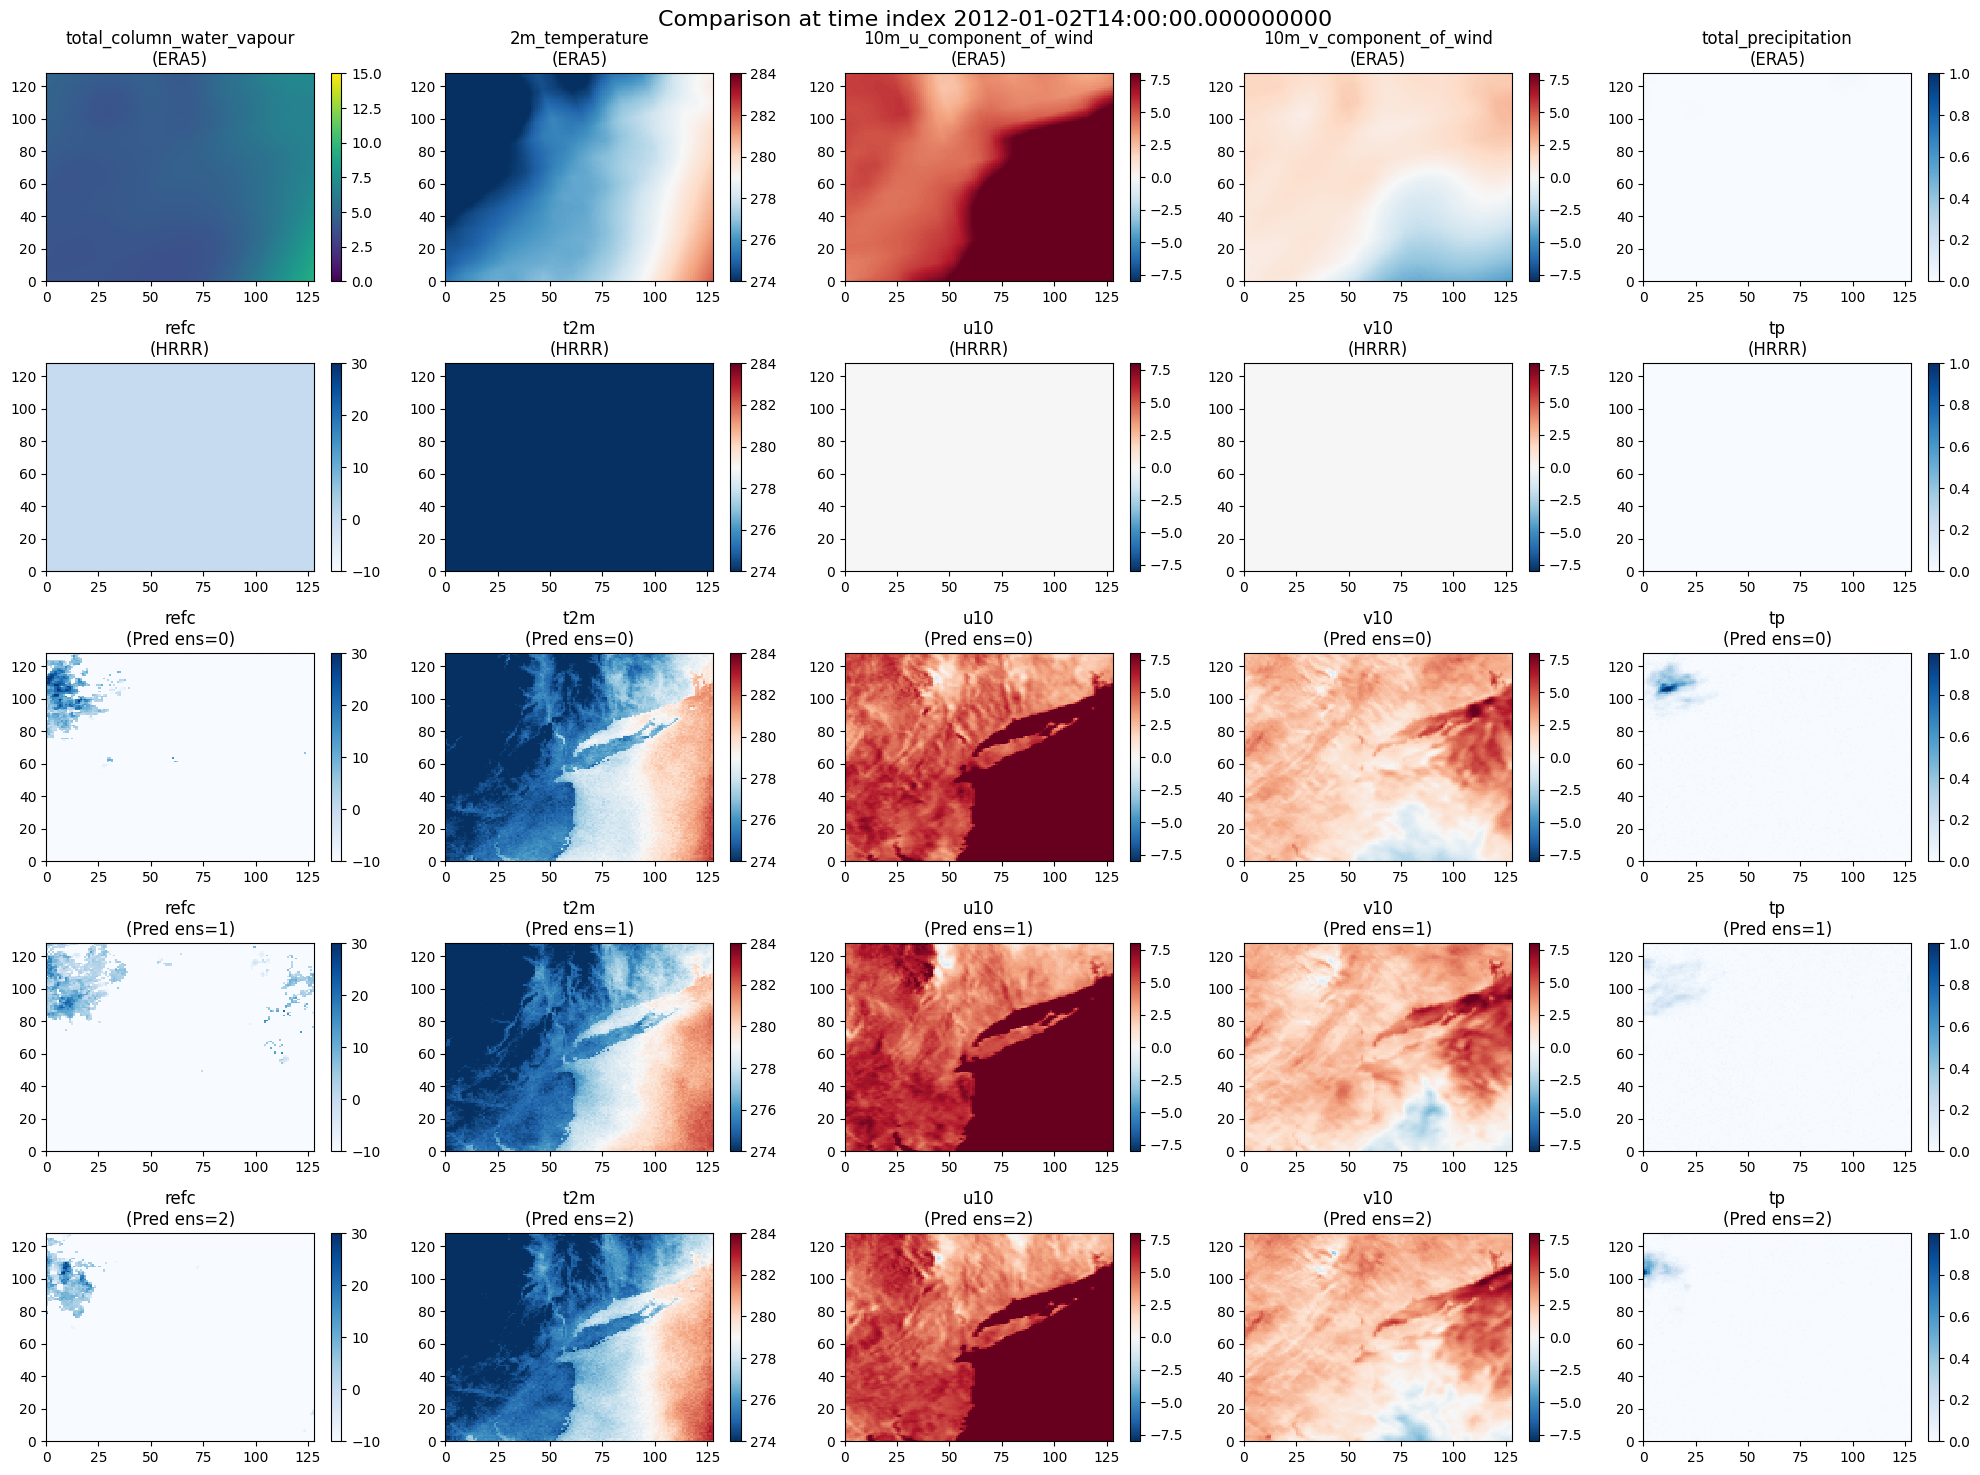

In [11]:
plot_comparison(ds_in, ds_tar, ds_out, common_channels, time_idx=38, ensembles=[0, 1, 2],
                vmin_dict=vmin_dict, vmax_dict=vmax_dict, cmap_dict=cmap_dict)

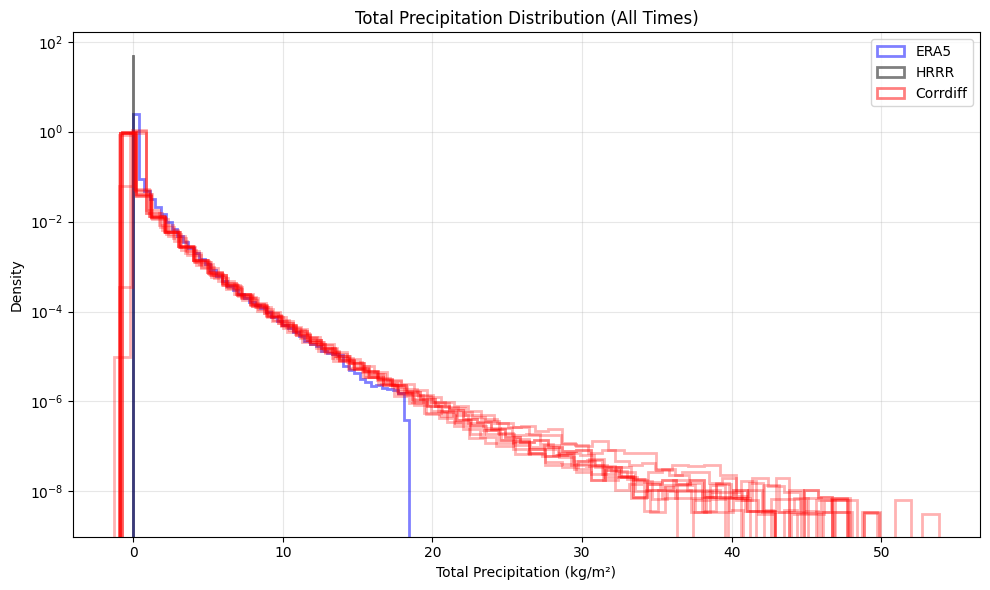

In [10]:
# Compare distributions across all times
plt.figure(figsize=(10, 6))

plt.hist(ds_in['total_precipitation'].values.flatten(), 
         bins=50, color='b', alpha=0.5, label='ERA5', density=True,histtype='step', linewidth=2)
plt.hist(ds_tar['tp'].values.flatten(), 
         bins=50, color='k', alpha=0.5, label='HRRR', density=True,histtype='step', linewidth=2)

for i in range(len(ds_out.ensemble)):
    alpha_val = 0.3 if i < len(ds_out.ensemble)-1 else 0.5
    label_val = 'Corrdiff' if i == len(ds_out.ensemble)-1 else None
    plt.hist(ds_out['tp'].isel(ensemble=i).values.flatten(), 
             bins=50, color='r', alpha=alpha_val, label=label_val, density=True,histtype='step', linewidth=2)

plt.xlabel('Total Precipitation (kg/m²)')
plt.ylabel('Density')
plt.title('Total Precipitation Distribution (All Times)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
#plt.xlim(0, 2)  # Adjust as needed
plt.tight_layout()

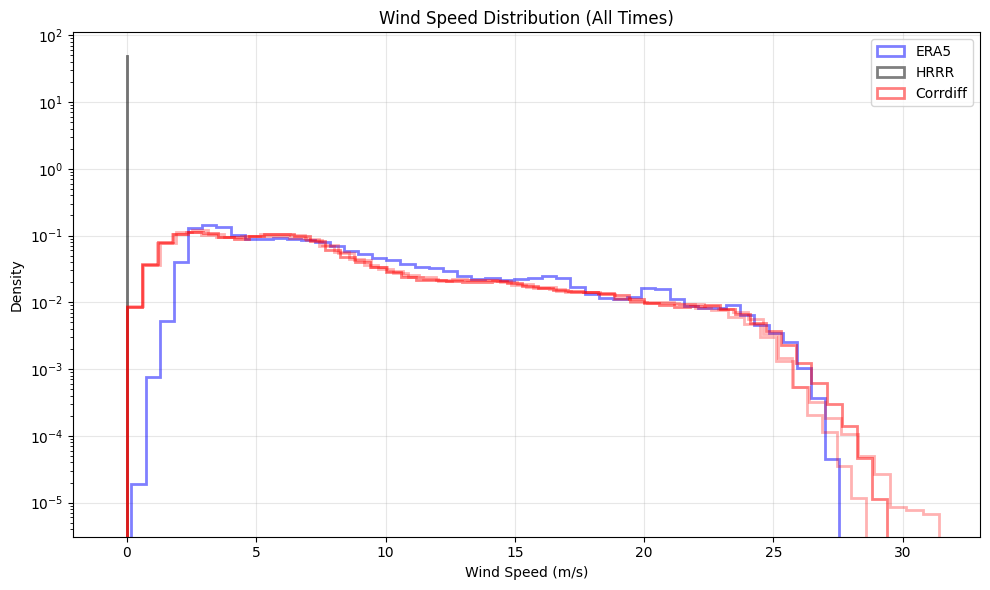

In [46]:
# Calculate wind speed magnitude
wind_speed_in = np.sqrt(ds_in['10m_u_component_of_wind'].values**2 + 
                        ds_in['10m_v_component_of_wind'].values**2)
wind_speed_tar = np.sqrt(ds_tar['u10'].values**2 + ds_tar['v10'].values**2)
wind_speed_out = np.sqrt(ds_out['u10'].values**2 + ds_out['v10'].values**2)

# Compare distributions across all times
plt.figure(figsize=(10, 6))

plt.hist(wind_speed_in.flatten(), 
         bins=50, color='b', alpha=0.5, label='ERA5', density=True, histtype='step', linewidth=2)
plt.hist(wind_speed_tar.flatten(), 
         bins=50, color='k', alpha=0.5, label='HRRR', density=True, histtype='step', linewidth=2)

for i in range(len(ds_out.ensemble)):
    alpha_val = 0.3 if i < len(ds_out.ensemble)-1 else 0.5
    label_val = 'Corrdiff' if i == len(ds_out.ensemble)-1 else None
    plt.hist(wind_speed_out[:, i, :, :].flatten(), 
             bins=50, color='r', alpha=alpha_val, label=label_val, density=True, 
             histtype='step', linewidth=2)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Wind Speed Distribution (All Times)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()

Text(0.5, 1.0, '2019')

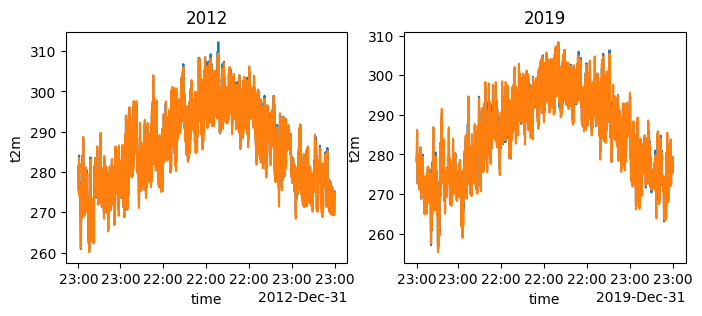

In [17]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
ds_in['2m_temperature'].isel(x=45,y=60).sel(time=slice('2012-01-01', '2012-12-31')).plot()
#ds_tar['t2m'].isel(x=45,y=60).plot()
ds_out['t2m'].isel(ensemble=0,x=45,y=60).sel(time=slice('2012-01-01', '2012-12-31')).plot()
plt.title('2012')

plt.subplot(1, 2, 2)
ds_in['2m_temperature'].isel(x=45,y=60).sel(time=slice('2019-01-01', '2019-12-31')).plot()
ds_out['t2m'].isel(ensemble=0,x=45,y=60).sel(time=slice('2019-01-01', '2019-12-31')).plot()
plt.title('2019')

In [14]:
wind_speed_in = np.sqrt(ds_in['10m_u_component_of_wind']**2 + 
                        ds_in['10m_v_component_of_wind']**2)
#wind_speed_tar = np.sqrt(ds_tar['u10'].values**2 + ds_tar['v10'].values**2)
wind_speed_out = np.sqrt(ds_out['u10']**2 + ds_out['v10']**2)

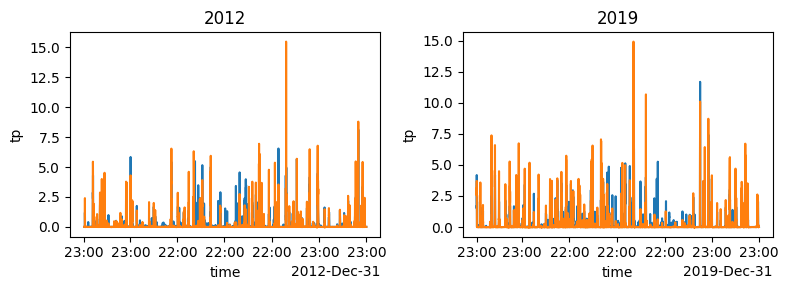

In [19]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
ds_in['total_precipitation'].isel(x=45,y=60).sel(time=slice('2012-01-01', '2012-12-31')).plot()
#ds_tar['t2m'].isel(x=45,y=60).plot()
ds_out['tp'].isel(ensemble=0,x=45,y=60).sel(time=slice('2012-01-01', '2012-12-31')).plot()
plt.title('2012')

plt.subplot(1, 2, 2)
ds_in['total_precipitation'].isel(x=45,y=60).sel(time=slice('2019-01-01', '2019-12-31')).plot()
ds_out['tp'].isel(ensemble=0,x=45,y=60).sel(time=slice('2019-01-01', '2019-12-31')).plot()
plt.title('2019')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
wind_speed_in.isel(x=45,y=60).sel(time=slice('2012-01-01', '2012-12-31')).plot()
wind_speed_out.isel(ensemble=0,x=45,y=60).sel(time=slice('2012-01-01', '2012-12-31')).plot()
plt.title('2012')

plt.subplot(1, 2, 2)
wind_speed_in.isel(x=45,y=60).sel(time=slice('2019-01-01', '2019-12-31')).plot()
wind_speed_out.isel(ensemble=0,x=45,y=60).sel(time=slice('2019-01-01', '2019-12-31')).plot()
plt.title('2019')

plt.tight_layout()

In [54]:
!pip install -q cartopy

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [58]:
ds_in['longitude']

<xarray.DataArray 'longitude' (y: 128, x: 128)> Size: 131kB
array([[283.55713164, 283.5911922 , 283.62524688, ..., 287.76675019,
        287.80001838, 287.83327979],
       [283.56506665, 283.59913913, 283.63320572, ..., 287.77612392,
        287.80940319, 287.84267566],
       [283.57300753, 283.60709195, 283.64117047, ..., 287.78550444,
        287.81879478, 287.85207833],
       ...,
       [284.59669063, 284.63230455, 284.66791172, ..., 288.99340207,
        289.02810739, 289.06280495],
       [284.60541313, 284.64104001, 284.67666013, ..., 289.00368236,
        289.03839962, 289.07310911],
       [284.61414239, 284.64978224, 284.68541532, ..., 289.01397041,
        289.04869961, 289.08342105]])
Coordinates:
    latitude             (y, x) float64 131kB 39.53 39.53 39.52 ... 41.98 41.97
    longitude            (y, x) float64 131kB 283.6 283.6 283.6 ... 289.0 289.1
    atmosphere           float64 8B 0.0
    gribfile_projection  float64 8B nan
    step                 timedelta64[ns] 8B 00:00:00
Dimensions without coordinates: y, x
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

In [ ]:
ds_in

/home/lep-zerjs/.local/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/lep-zerjs/.local/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


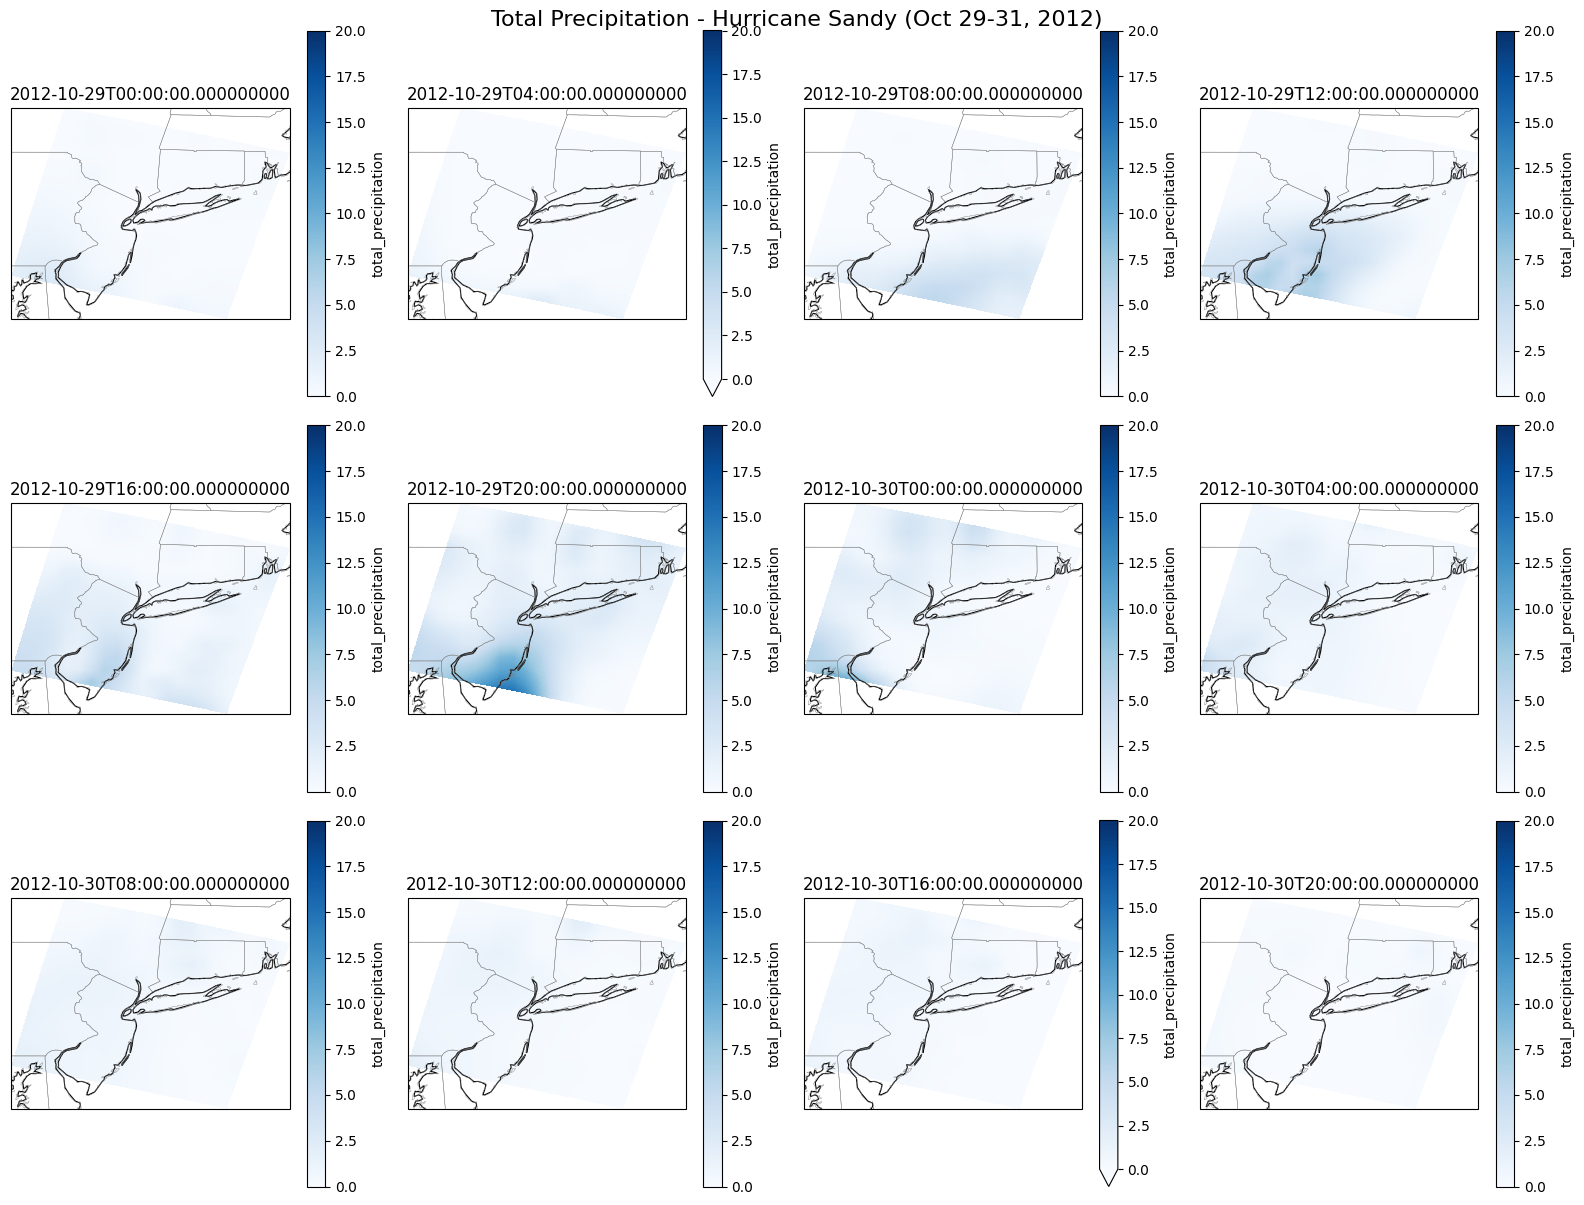

In [59]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Select 12 timesteps: 6 before, the event, and 5 after (every 6 hours)
center_time = '2012-10-30'
times = ds_in['total_precipitation'].sel(time=slice('2012-10-29 00:00', '2012-10-31 23:00')).time[::4]  # Every 6 hours

fig = plt.figure(figsize=(16, 12))

for i, t in enumerate(times[:12]):  # Limit to 12 plots
    ax = fig.add_subplot(3, 4, i+1, projection=ccrs.PlateCarree())
    
    # Plot the precipitation with fixed color range
    ds_in['total_precipitation'].sel(time=t).plot(x='longitude', y='latitude', ax=ax, cmap='Blues', add_colorbar=True,
                                    transform=ccrs.PlateCarree(),
                                    vmin=0, vmax=0.02*1000)
    
    # Add coastlines and borders
    ax.coastlines(resolution='50m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray')
    
    ax.set_title(f"{t.values}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.suptitle('Total Precipitation - Hurricane Sandy (Oct 29-31, 2012)', 
             fontsize=16, y=1.00)
plt.show()